# Expected price & return
* Increase test window and the log-returns and rolling volatiity to dynamically switch regime, and forecast volatility.
* Uses monte carlo simulation to probabilistic estimate of return in next time steps.
* Unfold forecasted returns to compute price and plot price chart.

## Import & Setup Parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from hmmlearn.hmm import GaussianHMM # for 2 state regime detection
from sklearn.preprocessing import StandardScaler, RobustScaler # transform for HMM/regime detection

from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
# parameters
SEED = 42
target = 1
horizon = 21*3
rolling_window = 21 
regime_window = 15
N_SIM = 1000

## Data Preparation

In [3]:
df = yf.download('MSFT', start='2014-01-01', auto_adjust=True, progress=False)
df.dropna(inplace=True)
df['LogReturn'] = np.log(df['Close']).diff()
df["pctLogReturn"] = df['LogReturn'] * 100 
df.dropna(inplace=True, axis=0)
df_train, df_test = df[:'2022-01-01'], df['2022-01-01':]

In [4]:
df.columns.get_level_values(0)

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'LogReturn', 'pctLogReturn'], dtype='object', name='Price')

Our pct log returns have t-distribution, student's t-HMM would like perform better. 

In [4]:
def ghmm(train, test, name='', **params):
    model = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000, random_state=SEED, tol=1e-10, **params)
    if not isinstance(train, np.ndarray):
        X = train.values.reshape(-1, 1)
        X_ = test.values.reshape(-1, 1)

    model.fit(X)
    
    print(name, 'show', model.monitor_.converged, 'convergence')
    print('Training score', model.score(X)/len(X[0]))
    print('Testing score', model.score(X_)/len(X_[0]))

    print("Means per regime:")
    print(model.means_)

    print("Covariances per regime:")
    print(model.covars_)
    
    plt.figure(figsize=(10,3))
    plt.scatter(test.index, X_, c=model.predict(X_), s=6, cmap='tab10')
    plt.title(f'HMM regime color for {name}'); plt.show()

Model is not converging.  Current: 5751.277983368231 is not greater than 5751.286175160364. Delta is -0.008191792133402487


log-return data show True convergence
Training score 5751.252174340146
Testing score 2803.295376174381
Means per regime:
[[ 0.00156702]
 [-0.0013389 ]]
Covariances per regime:
[[[0.00012942]]

 [[0.00122175]]]


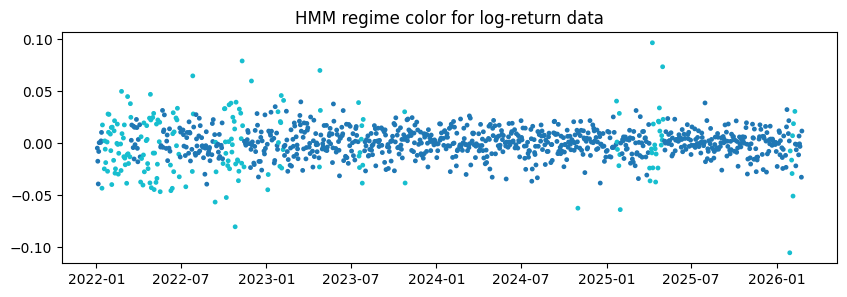

In [5]:
ghmm(df_train[['LogReturn']], df_test[['LogReturn']], name='log-return data')

In [6]:
features = df_train['LogReturn'].rolling(rolling_window).std()
features.name = 'rolling_vol'
features = pd.concat([features, df_train['LogReturn']], axis=1).dropna()

Converged: True
Means:
 [[0.00146388 0.01137954]
 [0.00019946 0.02495596]]


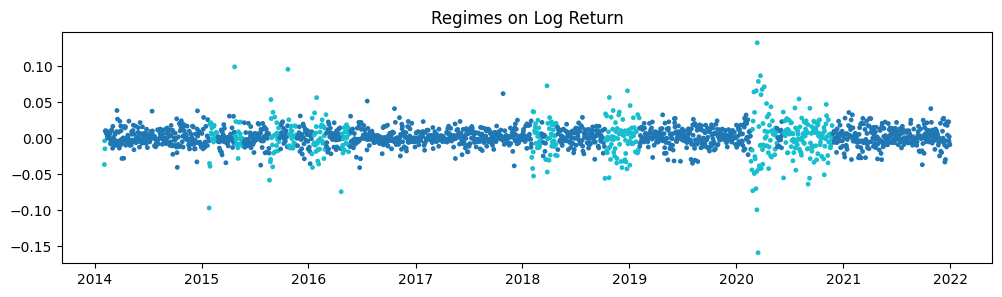

In [7]:
X = features[['LogReturn', 'rolling_vol']].values

model = GaussianHMM(n_components=2, covariance_type='full', 
                    n_iter=1000, random_state=42, tol=1e-10)
model.fit(X)

print("Converged:", model.monitor_.converged)
print("Means:\n", model.means_)

regimes = pd.Series(model.predict(X), index=features.index)

plt.figure(figsize=(12, 3))
plt.scatter(features.index, features['LogReturn'], 
            c=regimes, s=6, cmap='tab10')
plt.title('Regimes on Log Return')
plt.show()

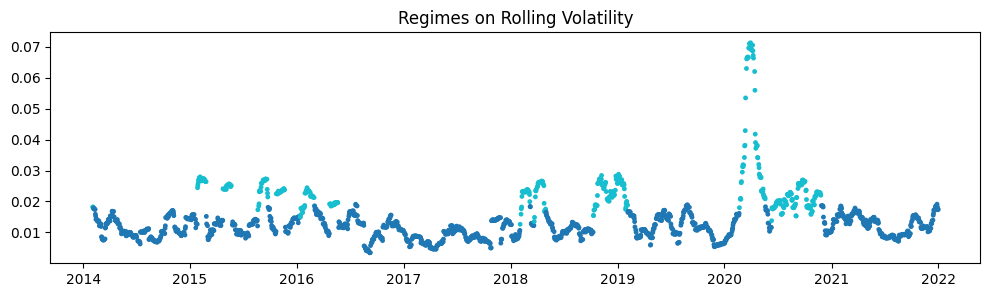

In [8]:
plt.figure(figsize=(12, 3))
plt.scatter(features.index, features['rolling_vol'], 
            c=regimes, s=6, cmap='tab10')
plt.title('Regimes on Rolling Volatility')
plt.show()

In [9]:
# Identify which state is high vol
high_vol_state = model.means_[:, 1].argmax()  # whichever has higher rolling_vol mean

regime_labels = regimes.map({high_vol_state: 'high', 1 - high_vol_state: 'low'})

# Split returns by regime
low_returns = features.loc[regime_labels == 'low', 'LogReturn']
high_returns = features.loc[regime_labels == 'high', 'LogReturn']

print("Low regime days:", len(low_returns))
print("High regime days:", len(high_returns))

Low regime days: 1540
High regime days: 454


HMM gave 30% High regime, which were only 5% in hysteresis based volatility regime 

In [10]:
# GARCH on low volatility regime
garch_model = arch_model(low_returns, vol='GARCH', p=1, q=1, dist='normal')
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4707.62
Distribution:                  Normal   AIC:                          -9407.24
Method:            Maximum Likelihood   BIC:                          -9385.88
                                        No. Observations:                 1540
Date:                Wed, Feb 25 2026   Df Residuals:                     1539
Time:                        18:50:37   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.5531e-03  2.778e-04      5.590  2.274e-08 [1.

In [11]:
# egarch for high regime
egarch_model = arch_model(high_returns, vol='EGARCH', p=1, q=1, dist='normal')
egarch_fit = egarch_model.fit(disp='off')
print(egarch_fit.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                1027.84
Distribution:                  Normal   AIC:                          -2047.68
Method:            Maximum Likelihood   BIC:                          -2031.20
                                        No. Observations:                  454
Date:                Wed, Feb 25 2026   Df Residuals:                      453
Time:                        18:50:37   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.9069e-03  1.216e-03      1.568      0.117 

Monte Carlo Price Simulation on test data

In [37]:
test_features = df['LogReturn'].rolling(rolling_window).std()
test_features.name = 'rolling_vol'
test_features.loc[df_test.index.min():]
test_features = pd.concat([test_features, df_test['LogReturn']], axis=1).dropna(axis=0)

In [38]:
X_test = test_features[['LogReturn', 'rolling_vol']].values
test_regimes = pd.Series(model.predict(test_features), index=test_features.index)
test_regime_labels = test_regimes.map({high_vol_state: 'high', 
                                       1 - high_vol_state: 'low'})
start_price = df.loc[test_features.index.min(), 'Close']

In [40]:
test_vols = np.zeros(len(test_regime_labels))

last_garch_var = garch_fit.conditional_volatility.iloc[-1] ** 2
last_egarch_var = egarch_fit.conditional_volatility.iloc[-1] ** 2

garch_omega = garch_fit.params['omega']
garch_alpha = garch_fit.params['alpha[1]']
garch_beta = garch_fit.params['beta[1]']

egarch_omega = egarch_fit.params['omega']
egarch_alpha = egarch_fit.params['alpha[1]']
egarch_beta = egarch_fit.params['beta[1]']

garch_var = last_garch_var
egarch_var = last_egarch_var

for t, regime in enumerate(test_regime_labels.values):
    if regime == 'low':
        garch_var = garch_omega + garch_alpha * garch_var + garch_beta * garch_var
        test_vols[t] = np.sqrt(garch_var)
    else:
        egarch_var = np.exp(egarch_omega + egarch_alpha * np.sqrt(egarch_var) + egarch_beta * np.log(egarch_var))
        test_vols[t] = np.sqrt(egarch_var)

In [41]:
# Drift (regime-aware)
low_drift = 0.10 / 252   # 10% annual, calm regime
high_drift = 0.00 / 252  # 0% annual, volatile regime

# Simulation
N_SIM = 1000
np.random.seed(42)
simulations = np.zeros((N_SIM, len(test_regime_labels) + 1))
simulations[:, 0] = start_price

for t, regime in enumerate(test_regime_labels.values):
    vol = test_vols[t]
    drift = low_drift if regime == 'low' else high_drift
    shock = np.random.normal(0, vol, N_SIM)
    simulations[:, t+1] = simulations[:, t] * np.exp(drift + shock)

print("Median final price: {:.2f}".format(np.median(simulations[:, -1])))
print("Final price range: {:.2f} to {:.2f}".format(
    simulations[:, -1].min(), simulations[:, -1].max()))

Median final price: 324.51
Final price range: 20.73 to 3601.66


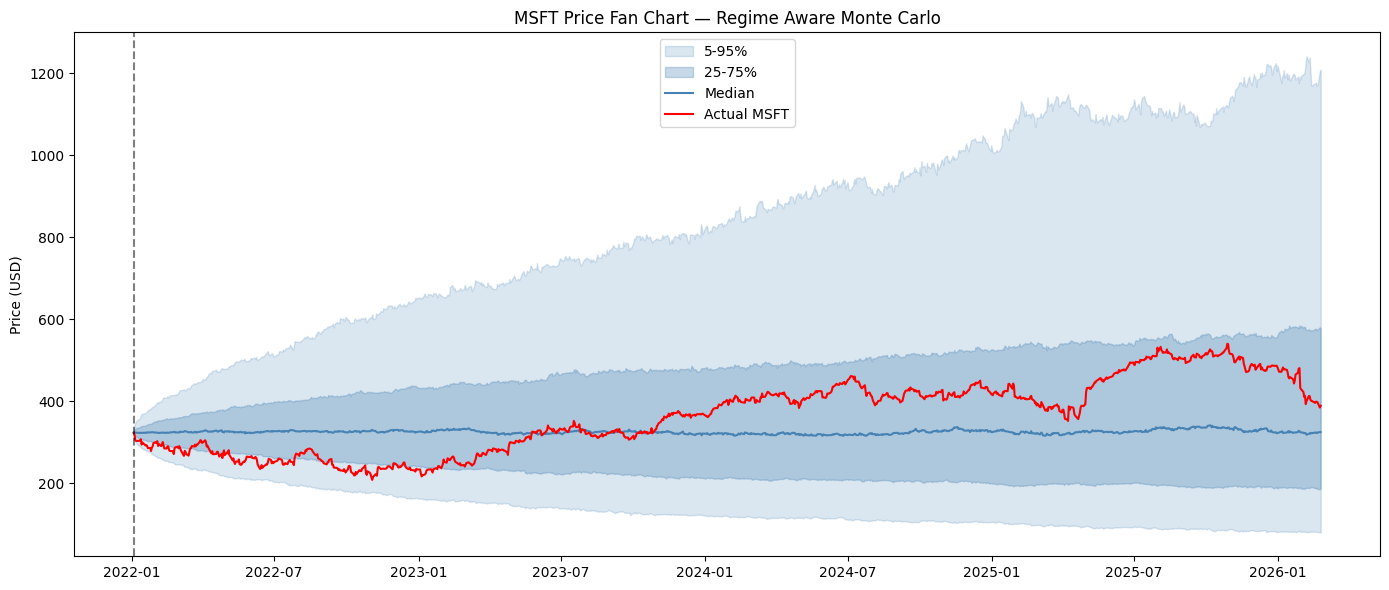

In [42]:
# Fan chart
percentiles = np.percentile(simulations, [5, 25, 50, 75, 95], axis=0)
actual_prices = df['Close'].loc[test_regime_labels.index]

fig, ax = plt.subplots(figsize=(14, 6))

ax.fill_between(test_regime_labels.index, percentiles[0, 1:], percentiles[4, 1:],
                alpha=0.2, color='steelblue', label='5-95%')
ax.fill_between(test_regime_labels.index, percentiles[1, 1:], percentiles[3, 1:],
                alpha=0.3, color='steelblue', label='25-75%')
ax.plot(test_regime_labels.index, percentiles[2, 1:],
        color='steelblue', linewidth=1.5, label='Median')
ax.plot(actual_prices.index, actual_prices.values,
        color='red', linewidth=1.5, label='Actual MSFT')

ax.axvline(x=test_regime_labels.index[0], color='black', linestyle='--', alpha=0.5)
ax.set_title('MSFT Price Fan Chart — Regime Aware Monte Carlo')
ax.set_ylabel('Price (USD)')
ax.legend()
plt.tight_layout()
plt.show()